In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

C:\Users\mattt\Anaconda3\envs\tf15\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
16068,-122.5,37.8,52.0,1457.0,292.0,621.0,315.0,4.6,450.0
8949,-118.9,34.0,19.0,15990.0,2611.0,5175.0,2173.0,7.8,500.0
9449,-119.2,34.3,30.0,2948.0,827.0,1635.0,750.0,2.7,214.9
12951,-121.8,37.3,28.0,1535.0,330.0,1937.0,317.0,4.1,160.1
865,-117.1,33.8,6.0,1771.0,293.0,935.0,279.0,4.1,148.2
...,...,...,...,...,...,...,...,...,...
309,-116.9,34.0,11.0,658.0,131.0,376.0,120.0,2.4,58.0
16978,-124.2,40.8,39.0,1836.0,352.0,883.0,337.0,1.7,70.5
2332,-117.5,33.9,34.0,2086.0,417.0,1501.0,395.0,3.2,105.6
11698,-121.3,38.1,31.0,335.0,53.0,154.0,55.0,2.1,175.0


In [2]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

Input Functions:
    Take in data, format that data, perform preprocessing steps, and create an iterator for stepping through the input

In [5]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create input functions.
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period {:02d} : {:0.2f}".format(period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): {:0.2f}".format(root_mean_squared_error))
  
  return calibration_data

Training model...
RMSE (on training data):
  period 00 : 237.51
  period 01 : 237.49
  period 02 : 237.46
  period 03 : 237.44
  period 04 : 237.41
  period 05 : 237.39
  period 06 : 237.36
  period 07 : 237.34
  period 08 : 237.31
  period 09 : 237.29
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,0.3,207.3
std,0.1,116.0
min,0.1,15.0
25%,0.2,119.4
50%,0.3,180.4
75%,0.3,265.0
max,6.2,500.0


Final RMSE (on training data): 237.29


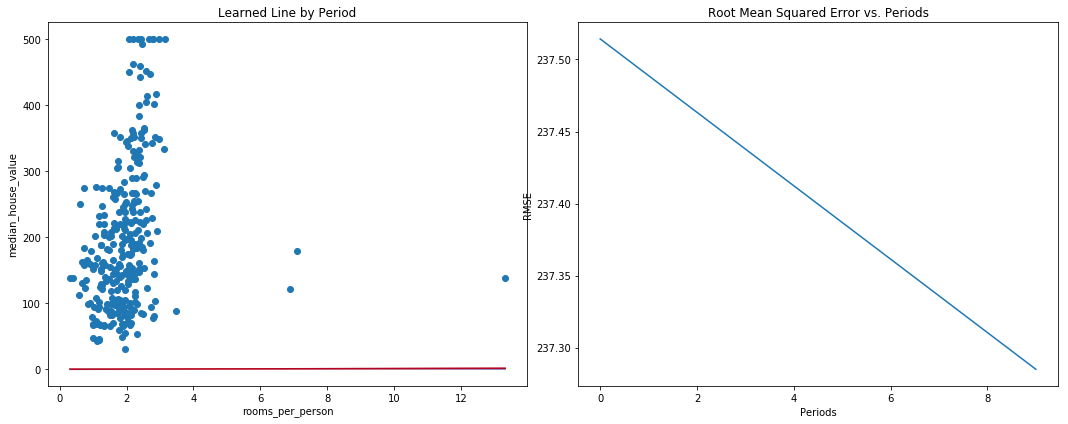

In [16]:
#
# YOUR CODE HERE
#
california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"]

calibration_data = train_model(
    learning_rate=0.00005,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person"
)

Training model...
RMSE (on training data):
  period 00 : 237.28
  period 01 : 237.03
  period 02 : 236.77
  period 03 : 236.52
  period 04 : 236.27
  period 05 : 236.01
  period 06 : 235.76
  period 07 : 235.50
  period 08 : 235.25
  period 09 : 234.99
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,2.8,207.3
std,1.3,116.0
min,0.6,15.0
25%,2.3,119.4
50%,2.7,180.4
75%,3.1,265.0
max,62.8,500.0


Final RMSE (on training data): 234.99


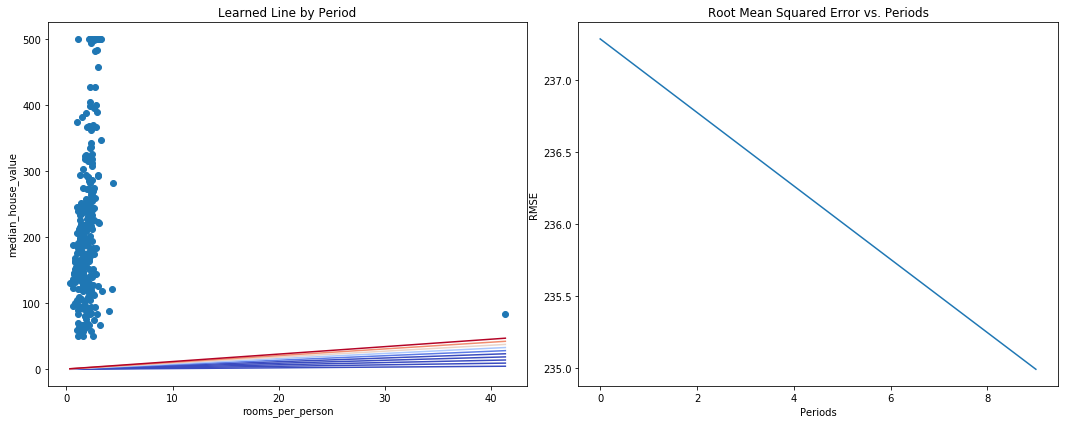

In [17]:
calibration_data = train_model(
    learning_rate=0.0005,
    steps=500,
    batch_size=25,
    input_feature="rooms_per_person"
)

Training model...
RMSE (on training data):
  period 00 : 234.99
  period 01 : 232.46
  period 02 : 229.94
  period 03 : 227.43
  period 04 : 224.94
  period 05 : 222.46
  period 06 : 220.00
  period 07 : 217.55
  period 08 : 215.12
  period 09 : 212.78
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,27.6,207.3
std,13.1,116.0
min,5.6,15.0
25%,22.5,119.4
50%,27.2,180.4
75%,31.2,265.0
max,624.3,500.0


Final RMSE (on training data): 212.78


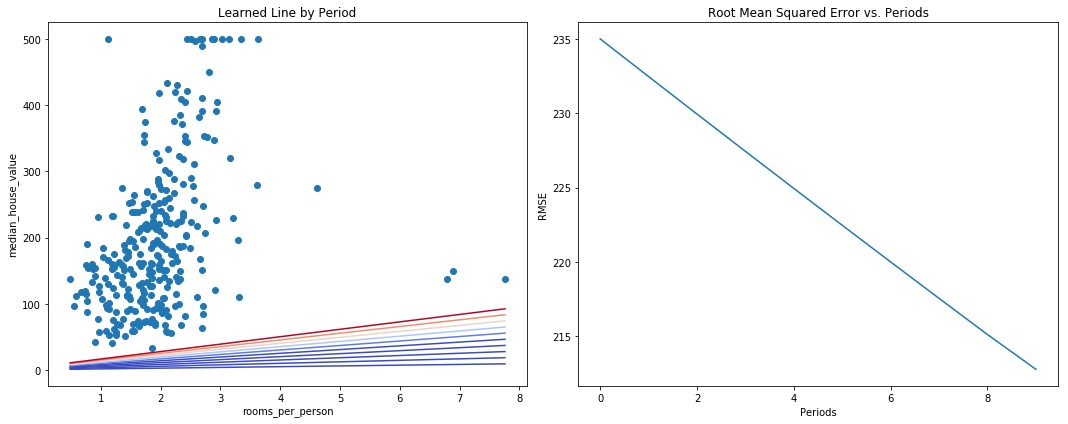

In [18]:
calibration_data = train_model(
    learning_rate=0.005,
    steps=500,
    batch_size=25,
    input_feature="rooms_per_person"
)

Training model...
RMSE (on training data):
  period 00 : 212.69
  period 01 : 189.99
  period 02 : 171.81
  period 03 : 153.92
  period 04 : 140.78
  period 05 : 133.24
  period 06 : 130.33
  period 07 : 130.16
  period 08 : 130.56
  period 09 : 129.74
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,200.0,207.3
std,86.5,116.0
min,54.8,15.0
25%,166.1,119.4
50%,197.1,180.4
75%,223.5,265.0
max,4138.4,500.0


Final RMSE (on training data): 129.74


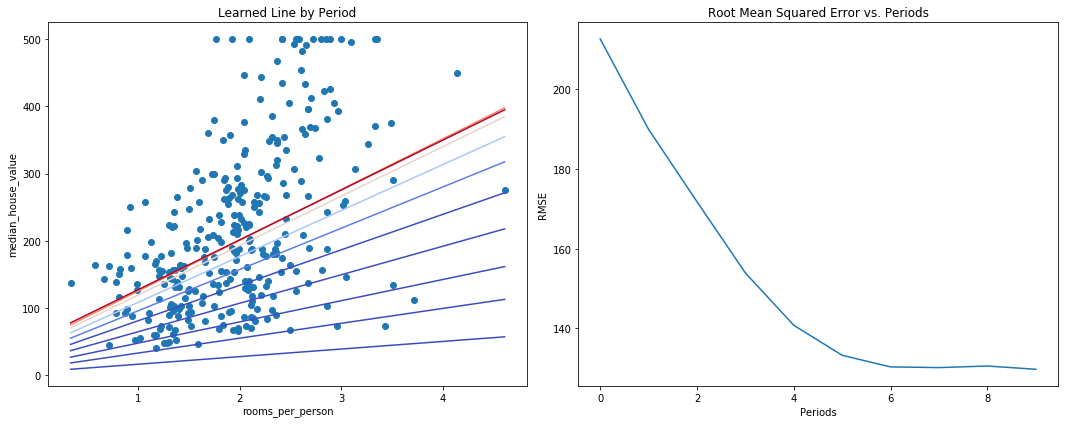

In [19]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=100,
    input_feature="rooms_per_person"
)

Training model...
RMSE (on training data):
  period 00 : 200.94
  period 01 : 168.98
  period 02 : 145.72
  period 03 : 134.59
  period 04 : 130.76
  period 05 : 131.26
  period 06 : 131.61
  period 07 : 132.96
  period 08 : 132.55
  period 09 : 132.77
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,203.6,207.3
std,92.9,116.0
min,47.7,15.0
25%,167.2,119.4
50%,200.5,180.4
75%,228.8,265.0
max,4432.1,500.0


Final RMSE (on training data): 132.77


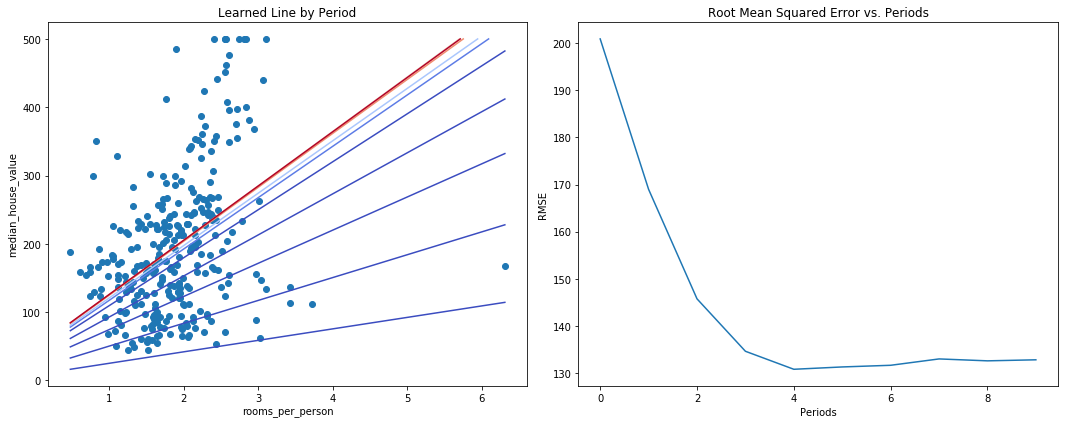

In [20]:
calibration_data = train_model(
    learning_rate=0.075,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person"
)

Training model...
RMSE (on training data):
  period 00 : 212.75
  period 01 : 190.35
  period 02 : 170.33
  period 03 : 152.82
  period 04 : 140.87
  period 05 : 134.61
  period 06 : 131.04
  period 07 : 130.69
  period 08 : 131.22
  period 09 : 131.39
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,195.9,207.3
std,89.3,116.0
min,46.0,15.0
25%,160.9,119.4
50%,192.9,180.4
75%,220.1,265.0
max,4261.3,500.0


Final RMSE (on training data): 131.39


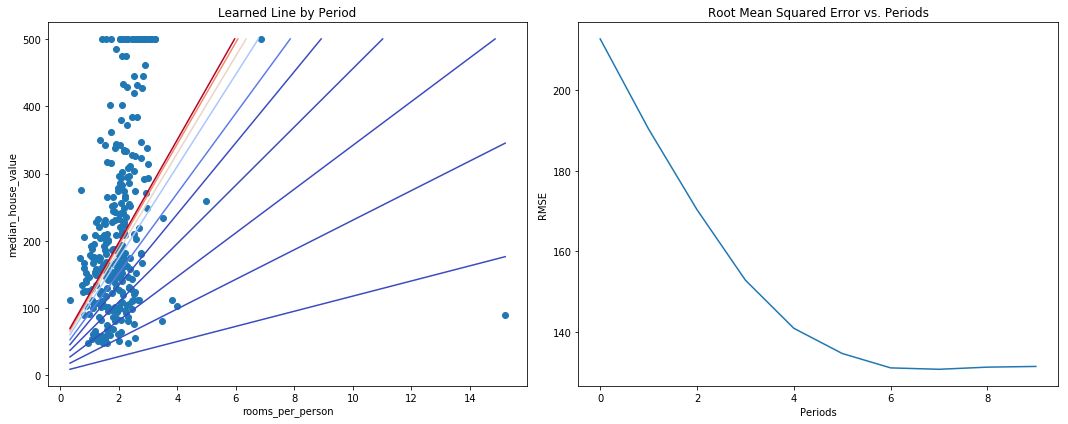

In [21]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person"
)

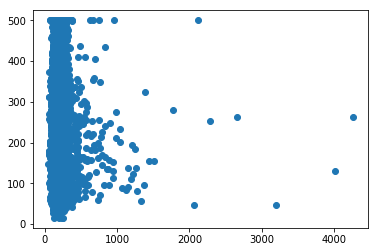

In [25]:
plt.scatter(x=calibration_data['predictions'], y=calibration_data['targets'])